Declare all imports

In [1]:
import random
from collections import Counter
from src import LIBRARY_ROOT
from src.dataobjs.cluster import Clusters
from src.dataobjs.dataset import WecDataSet
from src.dataobjs.mention_data import MentionData
from src.dataobjs.topics import Topics
from src.utils.io_utils import write_mention_to_json
from src.utils.sqlite_utils import select_all_from_clusters, create_connection
from src.utils.string_utils import StringUtils
import numpy as np
import math
from matplotlib import pyplot as plt


Measure Clusters and Mentions by type 

In [3]:
dev_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
            '/resources/dataset_full/wec/dev/Event_gold_mentions_validated2.json')

test_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
            '/resources/dataset_full/wec/test/Event_gold_mentions_validated2.json')

train_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
            '/resources/dataset_full/wec/train/Event_gold_mentions_validated3.json')

all_mentions = test_mentions

found = False
final_mentions = list()
all_types = dict()
for mention in all_mentions:
    if mention.mention_type not in all_types:
        all_types[mention.mention_type] = dict()
    if mention.coref_chain not in all_types[mention.mention_type]:
        all_types[mention.mention_type][mention.coref_chain] = 0
    all_types[mention.mention_type][mention.coref_chain] += 1

for _type in all_types.keys():
    print(str(_type) + "-Clusters=" + str(len(all_types[_type])))
    print(str(_type) + "-Mentions=" + str(sum([clust for clust in all_types[_type].values()])))
print("Done-" + str(all_types))

Remove Sport events and clean noise from location, date and nationality
 

In [3]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/wikilinks/Event_gold_mentions.json')

print("before=" + str(len(origin_mentions)))
new_mention = list()
removed = 0
for mention in origin_mentions:
    if mention.mention_type == 6:
        continue
    if 'colspan' in mention.mention_context:
        continue
        
    _, _, _, ner = StringUtils.find_head_lemma_pos_ner(mention.tokens_str)
    if StringUtils.is_verb_phrase(mention.tokens_str):
        new_mention.append(mention)
    elif ner not in ["GPE", "LOC", "DATE", "NORP", "PERSON"]:
        new_mention.append(mention)

print("total mentions remove=" + str(len(origin_mentions) - len(new_mention)))
print("total mentions in split-" + str(len(new_mention)))
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/wikilinks/Event_gold_mentions_1.json', new_mention)
print("Process Done!")

before=63857
total mentions remove=8977
total mentions in split-54880
Process Done!


REMOVE SINGLETONS (Experiment)


In [ ]:
topics_ = Topics()
topics_.create_from_file(
    str(LIBRARY_ROOT) + '/resources/dataset_full/wec/train/Event_gold_mentions_limit500_validated2.json', keep_order=True)
clusters = topics_.convert_to_clusters()

fin_mentions = list()
for ments_list in clusters.values():
    if len(ments_list) > 1:
        fin_mentions.extend(ments_list)

write_mention_to_json(
    str(LIBRARY_ROOT) + '/resources/dataset_full/wec/train/Event_gold_mentions_limit500.json', fin_mentions)


Sample clusters for validation


In [3]:
_event1 = str(LIBRARY_ROOT) + '/resources/dataset_full/wec/train/Event_gold_mentions_clean11.json'
mentions = MentionData.read_mentions_json_to_mentions_data_list(_event1)
clusters = Clusters.from_mentions_to_gold_clusters(mentions)
print(str(len(mentions)))
print(str(len(clusters)))
cluster_prop = [[clust_id] * len(clust) for clust_id, clust in clusters.items()]
cluster_prop = [item for sublist in cluster_prop for item in sublist]

selected_clust = set(random.sample(cluster_prop, 20))
while len(selected_clust) < 20:
    selected_clust.add(random.sample(cluster_prop, 1))    
print(selected_clust)

selected_ment = list()
for clust_id in selected_clust:
    if len(clusters[clust_id]) <= 5:
        selected_ment.extend(clusters[clust_id])
    else:
        selected_ment.extend(random.sample(clusters[clust_id], 5))

print(len(selected_ment))

write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/clusters_for_validation_take2.json', selected_ment)
print("Done!")

40529
7042
{3219718, 2541959, 12554, 2218259, 1993635, 1605805, 52655, 43451, 127298, 4056901, 136008, 604624, 1409750, 759129, 141535, 266727, 779752, 745328, 634485, 438010}
96
Done!


Create examples for manual validation (from unclean data)


In [4]:
valid_mentions = list()
valid1 = str(LIBRARY_ROOT) + '/resources/dataset_full/wec/dev/Event_gold_mentions_validated2.json'
valid2 = str(LIBRARY_ROOT) + '/resources/dataset_full/wec/test/Event_gold_mentions_validated2.json'
# all_mentions.extend(MentionData.read_mentions_json_to_mentions_data_list(valid1))
valid_mentions.extend(MentionData.read_mentions_json_to_mentions_data_list(valid2))
valid_clusters = Clusters.from_mentions_to_gold_clusters(valid_mentions)

non_valid_mentions = list()
not_valid1 = str(LIBRARY_ROOT) + '/resources/bkp/final_dataset_unclean/WEC_Dev_Full_Event_gold_mentions.json'
not_valid2 = str(LIBRARY_ROOT) + '/resources/bkp/final_dataset_unclean/WEC_Test_Full_Event_gold_mentions.json'
# all_mentions.extend(MentionData.read_mentions_json_to_mentions_data_list(not_valid1))
non_valid_mentions.extend(MentionData.read_mentions_json_to_mentions_data_list(not_valid2))
non_valid_cluters = Clusters.from_mentions_to_gold_clusters(non_valid_mentions)

final_mentions = list()
for cluster_id, mention_list in non_valid_cluters.items():
    if cluster_id not in valid_clusters:
        for mention in mention_list:
            if StringUtils.is_verb_phrase(mention.tokens_str):
                final_mentions.append(mention)
            elif mention.mention_ner not in ["GPE", "LOC", "DATE", "NORP", "PERSON"]:
                final_mentions.append(mention)

write_mention_to_json(str(LIBRARY_ROOT) + '/resources/bkp/final_dataset_unclean/WEC_All_Full_Event_gold_mentions_Not_valid.json', final_mentions)
print("Process Done!")

Remove Big clusters and see affect on dataset size


In [14]:
MAX_CLUST = 70

origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/train/Event_gold_mentions_clean3.json')

print("before=" + str(len(origin_mentions)))
clusters = Clusters.from_mentions_to_gold_clusters(origin_mentions)
new_mentions = list()
clusters_num = 0
for clust_key, clust in clusters.items():
    if len(clust) <= MAX_CLUST:
        clusters_num += 1
        new_mentions.extend(clust)

print("Clust=" + str(clusters_num))
print("Ment=" + str(len(new_mentions)))


Counting number of mentions in cluster with same string (and correlation with coref title)


In [6]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/ecb/train/Event_gold_mentions.json')

clusters = Clusters.from_mentions_to_gold_clusters(origin_mentions)
ret_counts = list()
total = 0
non_singleton_count = 0
for clust in clusters.values():
    clust_count = Counter([mention.tokens_str.lower() for mention in clust])
    if len(clust) > 1:
        total += max(clust_count.values())
        non_singleton_count += 1
    if hasattr(clust, 'coref_link'):
        ret_counts.append(clust[0].coref_link + "(" + str(len(clust)) + ")" + "=" + str(clust_count) + "\n")
    else:
        ret_counts.append(clust[0].coref_chain + "(" + str(len(clust)) + ")" + "=" + str(clust_count) + "\n")

f = open(str(LIBRARY_ROOT) + '/reports/wec.txt','w')
f.writelines(ret_counts)
f.close()

print("Average max same string in clust=" + str(total/non_singleton_count))
print("Done!")

Average max same string in clust=3.832116788321168
Done!


Adding mention link(coref page name) to mentions file

In [2]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/train/Event_gold_mentions_clean4.json')
connection = create_connection("/Users/aeirew/workspace/DataBase/EnWikiLinks_v11.db")
clusters = select_all_from_clusters(connection)

for mention in origin_mentions:
    if mention.coref_chain not in clusters:
        raise Exception("ERROR: No such coref_chain")
    
    mention.coref_link = clusters[mention.coref_chain]
    
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/train/Event_gold_mentions_clean5.jso', origin_mentions)

print("Done!")

Limit number of mentions with same string in cluster to MAX 

In [2]:
MAX = 4
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/wikilinks/Event_gold_mentions_1.json')

clusters = Clusters.from_mentions_to_gold_clusters(origin_mentions)
final_mentions = list()
for clust in clusters.values():
    clust_dict_names = dict()
    for mention in clust:
        if mention.tokens_str.lower() not in clust_dict_names:
            clust_dict_names[mention.tokens_str.lower()] = list()
        clust_dict_names[mention.tokens_str.lower()].append(mention)
        
    for ment_list in clust_dict_names.values():
        if len(ment_list) >= MAX:
            final_mentions.extend(list(random.sample(ment_list, MAX)))
        else:
            final_mentions.extend(ment_list)

final_clusters = Clusters.from_mentions_to_gold_clusters(final_mentions)
print("total mentions remove=" + str(len(origin_mentions) - len(final_mentions)))
print("total mentions in split-" + str(len(final_mentions)))
print("total clusters in split-" + str(len(final_clusters)))
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/wikilinks/Event_gold_mentions_2.json', final_mentions)            
print("Done!")

total mentions remove=33160
total mentions in split-21720
total clusters in split-2122
Done!


Filter mentions with span longer then MAX_SPAN

In [7]:
MAX_SPAN = 7

origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/train/Event_gold_mentions_clean7_uncut.json')

final_mentions = list()
for mention in origin_mentions:
    if (mention.tokens_number[-1] - mention.tokens_number[0]) <= MAX_SPAN:
        final_mentions.append(mention)
    
print("total mentions remove=" + str(len(origin_mentions) - len(final_mentions)))
print("total mentions in split-" + str(len(final_mentions)))
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/train/Event_gold_mentions_clean8_uncut.json', final_mentions)            
print("Done!")

Fix mention topic_id and mention_id

In [2]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/train/Event_gold_mentions_clean5_uncut.json')

index = 1
for mention in origin_mentions:
    mention.topic_id = -1
    mention.mention_id = index
    index += 1
    
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/train/Event_gold_mentions_clean6_uncut.json', origin_mentions)            
print("Done!")

Limit mention spans of verbs only to the VERB tokens

In [2]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/all/Event_gold_mentions_clean8_uncut_span7.json')

modified = 0
for mention in origin_mentions:
    if len(mention.tokens_number) > 1:
        phrase_index = StringUtils.extract_verb_phrase_index(mention)
        if len(phrase_index) > 0:
            modified += 1
            print("Before=" + mention.tokens_str)
            new_ment = " ".join(mention.mention_context[phrase_index[0]:phrase_index[-1] + 1]).strip()
            if len(new_ment) > 0:
                mention.tokens_str = new_ment
                mention.tokens_number = phrase_index
                print("After=" + mention.tokens_str)

print("Modified=" + str(modified))
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/all/Event_gold_mentions_clean9_uncut_verb.json', origin_mentions)            
print("Done!")

Remove mentions when context containin HTTP

In [2]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/train/Event_gold_mentions_clean6_uncut.json')
final_mentions = list()
for mention in origin_mentions:
    contx = " ".join(mention.mention_context)
    if "http" in contx:
        continue
    final_mentions.append(mention)
    
print("total mentions remove=" + str(len(origin_mentions) - len(final_mentions)))
print("total mentions in split-" + str(len(final_mentions)))
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/train/Event_gold_mentions_clean7.json', final_mentions)            
print("Done!")

Draw histograms of the data


[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 23, 25, 25, 25, 25, 26, 26, 28, 28, 29, 29, 29, 30, 33, 33, 34, 38, 38, 40, 41, 42, 43, 44, 46, 46, 52, 53, 56, 58, 63, 73, 73]


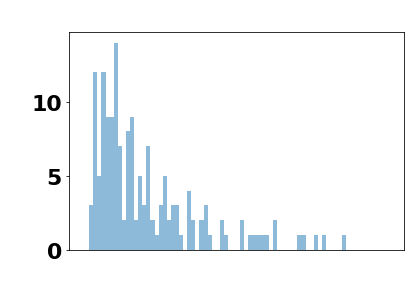

In [8]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 22}

mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/dev/Event_gold_mentions_clean11_v2.json')
clusters = Clusters.from_mentions_to_gold_clusters(mentions)


data = [len(clust) for clust in clusters.values() if len(clust) <= 80] 
print(str(sorted(data)))
bins = np.arange(math.ceil(min(data)), math.floor(max(data)), 1)

plt.rc('font', **font)
plt.rcParams.update({'text.color' : "white", 'axes.labelcolor' : "white"})
plt.rcParams.update({'xtick.color':'white'})

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('TRAIN')
plt.xlabel('Cluster Size')
plt.ylabel('Count')
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.show()

In [8]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/dev/dev_filtered_mentions_dont_use.json')

final_mentions = list()
for mention in origin_mentions:
    if StringUtils.is_verb_phrase(mention.tokens_str):
        final_mentions.append(mention)

print("Final=" + str(len(final_mentions)))
write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/dev/dev_filtered_verbs.json', final_mentions)            
print("Done!")

Final=77
Done!


In [9]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/train/Event_gold_mentions_clean11.json')

sample = random.sample(origin_mentions, 100)

write_mention_to_json(str(LIBRARY_ROOT) + '/resources/dataset_full/wec/sample.json', sample)

Extract distribution of infoboxs to events to mentions


In [7]:
origin_mentions = MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/train/Event_gold_mentions_clean12.json')

origin_mentions.extend(MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/dev/Event_gold_mentions_clean12_validated.json'))
origin_mentions.extend(MentionData.read_mentions_json_to_mentions_data_list(str(LIBRARY_ROOT) +
                       '/resources/dataset_full/wec/test/Event_gold_mentions_clean12_validated.json'))

clusters = Clusters.from_mentions_to_gold_clusters(origin_mentions)

conn = create_connection("/Users/aeirew/workspace/DataBase/EnWikiLinks_v11.db")
query = "SELECT * from CorefChains;"
cur = conn.cursor()
cur.execute(query)
rows = cur.fetchall()

sub_type_clust = dict()

for coref in rows:
    cluster_id = coref[0]
    cluster_link = coref[1]
    coref_sub_type = coref[4]
    if cluster_id in clusters:
        if coref_sub_type not in sub_type_clust:
            sub_type_clust[coref_sub_type] = list()
        sub_type_clust[coref_sub_type].append(len(clusters[cluster_id])) 

clusters_tot = 0
mention_tot = 0
for infobox_type, clust_sums in sub_type_clust.items():
    print("Sub_Type=" + str(infobox_type) + ", Clust=" + str(len(clust_sums)) + ", Ment=" + str(sum(clust_sums)))
    clusters_tot += len(clust_sums)
    mention_tot += sum(clust_sums)

print("clust tot=" + str(clusters_tot))
print("ment tot=" + str(mention_tot))
print("Done!")

Sub_Type=8, Clust=1178, Ment=9490
Sub_Type=49, Clust=1848, Ment=8910
Sub_Type=21, Clust=1212, Ment=5942
Sub_Type=22, Clust=541, Ment=2770
Sub_Type=50, Clust=268, Ment=2029
Sub_Type=2, Clust=387, Ment=3526
Sub_Type=5, Clust=121, Ment=990
Sub_Type=3, Clust=135, Ment=720
Sub_Type=9, Clust=230, Ment=1296
Sub_Type=7, Clust=31, Ment=343
Sub_Type=13, Clust=596, Ment=2640
Sub_Type=6, Clust=18, Ment=184
Sub_Type=19, Clust=262, Ment=1082
Sub_Type=18, Clust=241, Ment=1663
Sub_Type=20, Clust=65, Ment=345
Sub_Type=51, Clust=431, Ment=1616
Sub_Type=17, Clust=31, Ment=121
Sub_Type=14, Clust=2, Ment=5
clust tot=7597
ment tot=43672
Done!
